In [ ]:
# Import required libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
import keras.backend as K
import tensorflow as tf
plt.style.use('seaborn')
from sklearn.model_selection import RandomizedSearchCV
import os.path
from google.colab import drive
import pickle
from sklearn.metrics import r2_score
from datetime import datetime
from tensorflow.keras.models import  load_model


<ipython-input-1-11e574450fb3>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# selecting the stock for the study
# Change the ticker name to desired stock for the prediction
ticker = "RELIANCE.NS"
start_date = "1990-01-01"
end_date = "2022-12-31"

In [ ]:
# Download data for Reliance stock from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)
data['Volume'].replace(to_replace=0, method='ffill', inplace=True)
data.sort_values('Date', inplace=True)
print(len(data))
# Applying rolling mean to the data
data[['Open', 'High', 'Low', 'Close', 'Volume']] = data[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean()
data = data.dropna()
data.head()

[*********************100%%**********************]  1 of 1 completed
6790


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-12,15.264121,15.497757,14.999925,15.208419,9.520057,115489337.0
1996-01-15,15.125254,15.357730,14.852549,15.052919,9.421103,119913282.3
1996-01-16,14.968594,15.208806,14.711361,14.912505,9.438864,122151753.3
1996-01-17,14.794527,14.963565,14.493197,14.702851,9.063339,126319374.7
1996-01-18,14.564758,14.750817,14.266910,14.469602,8.812141,133731179.6


In [ ]:
raw_data = data
# Initialise the parameters
seq_len = 128

In [ ]:
# Calculating Percentage Change of all the columns
returns = data['Close'].pct_change()
data['Open'] = data['Open'].pct_change()
data['High'] = data['High'].pct_change()
data['Low'] = data['Low'].pct_change()
volume_changes = data['Volume'].pct_change()

# Add the returns and volume changes as new columns to the DataFrame
data['returns'] = returns
data['volume_changes'] = volume_changes
data_initial = data
data = data.dropna()
data.head()

<ipython-input-79-a93379c93db3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Open'] = data['Open'].pct_change()
<ipython-input-79-a93379c93db3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['High'] = data['High'].pct_change()
<ipython-input-79-a93379c93db3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

,Open,High,Low,Close,Adj Close,Volume,returns,volume_changes
Date,,,,,,,,
1996-01-15,-0.009098,-0.009035,-0.009825,15.052919,9.421103,119913282.3,-0.010225,0.038306
1996-01-16,-0.010358,-0.009697,-0.009506,14.912505,9.438864,122151753.3,-0.009328,0.018667
1996-01-17,-0.011629,-0.016125,-0.014830,14.702851,9.063339,126319374.7,-0.014059,0.034118
1996-01-18,-0.015531,-0.014218,-0.015613,14.469602,8.812141,133731179.6,-0.015864,0.058675
1996-01-19,-0.016865,-0.015524,-0.016918,14.223587,8.657367,141014887.2,-0.017002,0.054465


In [ ]:
# Calculate Moving Average Convergence Divergence (MACD)
def calculate_macd(data, ema_short=12, ema_long=26, signal_period=9):
    # Calculate the short-term EMA
    ema_short = data['returns'].ewm(span=ema_short, adjust=False).mean()
    # Calculate the long-term EMA
    ema_long = data['returns'].ewm(span=ema_long, adjust=False).mean()
    # Calculate the MACD line
    macd_line = ema_short - ema_long
    # Calculate the signal line
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    # Calculate the MACD histogram
    macd_histogram = macd_line - signal_line
    return macd_line, signal_line, macd_histogram

In [ ]:
macd_line, signal_line, macd_histogram = calculate_macd(data)
# Add MACD, MACD_signal, MACD_histogram as new columns to the DataFrame
data['MACD'] = macd_line
data['MACD_signal'] = signal_line
data['MACD_histogram'] = macd_histogram
data = data.dropna()
data.head()

<ipython-input-81-5dec7da196af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MACD'] = macd_line
<ipython-input-81-5dec7da196af>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MACD_signal'] = signal_line
<ipython-input-81-5dec7da196af>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

,Open,High,Low,Close,Adj Close,Volume,returns,volume_changes,MACD,MACD_signal,MACD_histogram
Date,,,,,,,,,,,
1996-01-15,-0.009098,-0.009035,-0.009825,15.052919,9.421103,119913282.3,-0.010225,0.038306,0.000000,0.000000,0.000000
1996-01-16,-0.010358,-0.009697,-0.009506,14.912505,9.438864,122151753.3,-0.009328,0.018667,0.000072,0.000014,0.000057
1996-01-17,-0.011629,-0.016125,-0.014830,14.702851,9.063339,126319374.7,-0.014059,0.034118,-0.000251,-0.000039,-0.000212
1996-01-18,-0.015531,-0.014218,-0.015613,14.469602,8.812141,133731179.6,-0.015864,0.058675,-0.000644,-0.000160,-0.000484
1996-01-19,-0.016865,-0.015524,-0.016918,14.223587,8.657367,141014887.2,-0.017002,0.054465,-0.001036,-0.000335,-0.000701


In [ ]:
start_date = "2021-06-01"
end_date = "2022-12-31"
subset_data = data.loc[(data.index >= start_date) & (data.index <= end_date)]


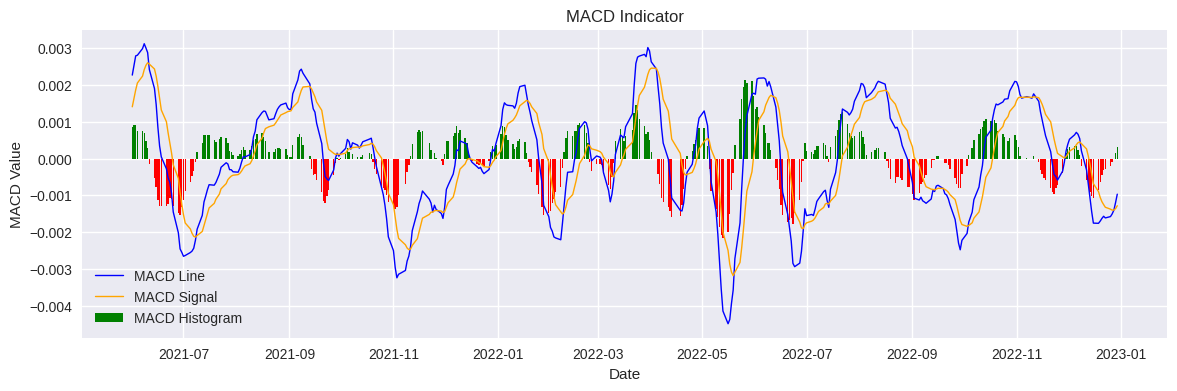

In [ ]:
# Plot MACD indicator
plt.figure(figsize=(14,4))
colours = np.array(['green']*len(subset_data['MACD_histogram']))
colours[subset_data['MACD_histogram']<0] = 'red'
plt.plot(subset_data.index.values, subset_data['MACD'], label='MACD Line', color='blue', linewidth=1)
plt.plot(subset_data.index.values, subset_data['MACD_signal'], label='MACD Signal', color = 'orange', linewidth=1)
plt.bar(subset_data.index.values, subset_data['MACD_histogram'], label='MACD Histogram', color = colours)
plt.title('MACD Indicator')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Drop unwanted columns
# Only run once
#data = data.drop('Date', axis=1)
data = data.drop('Close', axis=1)
data = data.drop('Volume', axis=1)
data = data.drop('Adj Close', axis=1)
data.head()

,Open,High,Low,returns,volume_changes,MACD,MACD_signal,MACD_histogram
Date,,,,,,,,
1996-01-15,-0.009098,-0.009035,-0.009825,-0.010225,0.038306,0.000000,0.000000,0.000000
1996-01-16,-0.010358,-0.009697,-0.009506,-0.009328,0.018667,0.000072,0.000014,0.000057
1996-01-17,-0.011629,-0.016125,-0.014830,-0.014059,0.034118,-0.000251,-0.000039,-0.000212
1996-01-18,-0.015531,-0.014218,-0.015613,-0.015864,0.058675,-0.000644,-0.000160,-0.000484
1996-01-19,-0.016865,-0.015524,-0.016918,-0.017002,0.054465,-0.001036,-0.000335,-0.000701


In [ ]:
# Splitting the dataset
times = sorted(data.index.values)
last_10pct = sorted(data.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(data.index.values)[-int(0.2*len(times))] # Last 20% of series
print(last_10pct)
print(last_20pct)

2020-04-15T00:00:00.000000000
2017-07-10T00:00:00.000000000


In [ ]:
# Setting the feature and target columns
feature_values = ['Open', 'High', 'Low','returns', 'volume_changes', 'MACD', 'MACD_signal', 'MACD_histogram']
target_value = ['returns']

In [ ]:
df_train = data[(data.index < last_20pct)]  # Training data are 80% of total data
df_val = data[(data.index >= last_20pct) & (data.index < last_10pct)]
df_test = data[(data.index >= last_10pct)]
print(len(df_train))
print(len(df_val))
print(len(df_test))
df_train.head()

5424
678
678


,Open,High,Low,returns,volume_changes,MACD,MACD_signal,MACD_histogram
Date,,,,,,,,
1996-01-15,-0.009098,-0.009035,-0.009825,-0.010225,0.038306,0.000000,0.000000,0.000000
1996-01-16,-0.010358,-0.009697,-0.009506,-0.009328,0.018667,0.000072,0.000014,0.000057
1996-01-17,-0.011629,-0.016125,-0.014830,-0.014059,0.034118,-0.000251,-0.000039,-0.000212
1996-01-18,-0.015531,-0.014218,-0.015613,-0.015864,0.058675,-0.000644,-0.000160,-0.000484
1996-01-19,-0.016865,-0.015524,-0.016918,-0.017002,0.054465,-0.001036,-0.000335,-0.000701


In [ ]:
# Scale the features using Standard Scalar
scaler = StandardScaler()
scaler.fit_transform(df_train[feature_values])
df_train[feature_values] = scaler.transform(df_train[feature_values])
df_test[feature_values] = scaler.transform(df_test[feature_values])
df_val[feature_values] = scaler.transform(df_val[feature_values])

scaler.fit_transform(df_train[target_value])
df_train[target_value] = scaler.transform(df_train[target_value])
df_test[target_value] = scaler.transform(df_test[target_value])
df_val[target_value] = scaler.transform(df_val[target_value])

# Convert the data to numpy arrays
train_data = df_train[feature_values].values
train_data_target = df_train[target_value].values

val_data = df_val[feature_values].values
val_data_target = df_val[target_value].values

test_data = df_test[feature_values].values
test_data_target = df_test[target_value].values

<ipython-input-86-9ae68f08d3b1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[feature_values] = scaler.transform(df_train[feature_values])
<ipython-input-86-9ae68f08d3b1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[feature_values] = scaler.transform(df_test[feature_values])
<ipython-input-86-9ae68f08d3b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

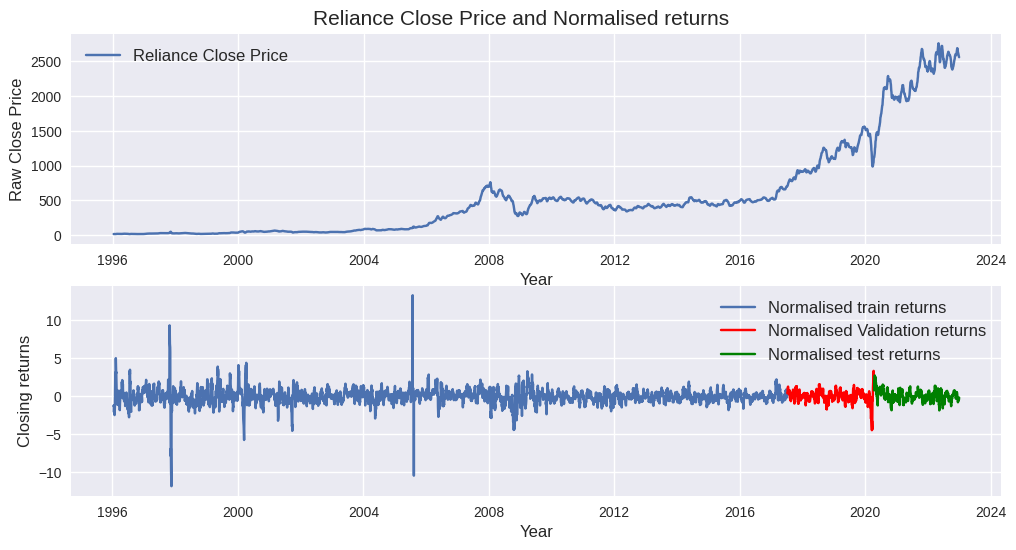

In [ ]:
# Plot Real close price and after normalisation
fig = plt.figure(figsize=(12,6))
st = fig.suptitle("Close Price and Normalised returns", fontsize=15)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(data_initial['Close'], label='Close Price')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Raw Close Price', fontsize=12)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df_train['returns'], label='Normalised train returns')
ax2.plot(df_val['returns'], label='Normalised Validation returns', color='red')
ax2.plot(df_test['returns'], label='Normalised test returns', color='green')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Closing returns', fontsize=12)
ax2.legend(loc="best", fontsize=12)

In [ ]:
# Training data
train_date = []
x_train, y_train = [], []
for i in range(seq_len, len(df_train)):
   x_train.append(df_train.iloc[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
   y_train.append(df_train.iloc[i, 3]) #Value of 8th column (Close Price) of df-row 128+1
   train_date.append(df_train.index.values[i])
x_train, y_train, train_date = np.array(x_train), np.array(y_train), np.array(train_date)

print(train_date)

# Validation data
val_date=[]
x_val, y_val = [], []
for i in range(seq_len, len(df_val)):
    x_val.append(df_val.iloc[i-seq_len:i])
    y_val.append(df_val.iloc[i, 3])
    val_date.append(df_val.index.values[i])
x_val, y_val, val_date = np.array(x_val), np.array(y_val), np.array(val_date)


# Test data
test_date=[]
x_test, y_test = [], []
for i in range(seq_len, len(df_test)):
    x_test.append(df_test.iloc[i-seq_len:i])
    y_test.append(df_test.iloc[i, 3])
    test_date.append(df_test.index.values[i])
x_test, y_test = np.array(x_test), np.array(y_test)


print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)



['1996-07-11T00:00:00.000000000' '1996-07-12T00:00:00.000000000'
 '1996-07-15T00:00:00.000000000' ... '2017-07-05T00:00:00.000000000'
 '2017-07-06T00:00:00.000000000' '2017-07-07T00:00:00.000000000']
(5296, 128, 8) (5296,)
(550, 128, 8) (550,)
(550, 128, 8) (550,)


In [ ]:
tf.random.set_seed(2)

In [ ]:
# Transformer model
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention part
    print(inputs.shape)
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed forward layer
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
# Method for transformer parameters
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    print(inputs.shape)
    x = inputs
    # Calling Transformer block
    for i in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)


In [ ]:
input_shape = x_train.shape[1:]
print('Input shape: ',input_shape)
# Calling build_model with the best hyperparameter values
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)
model.summary()

Input shape:  (128, 8)
(None, 128, 8)
(None, 128, 8)
(None, 128, 8)
(None, 128, 8)
(None, 128, 8)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 8)]     0           []                               
                                                                                                  
 layer_normalization_32 (LayerN  (None, 128, 8)      16          ['input_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_16 (Multi  (None, 128, 8)      35848       ['layer_normalization_32[0][0]', 
 HeadAttention)                                                   'layer_normalization_32[0][

In [ ]:
# Method for calculating rmse
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

In [ ]:
# Model comilation
model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(learning_rate=0.007),
              metrics=['mae',rmse, 'mape'])

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)]
# Model fitting
history = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=30, batch_size=64,callbacks=callbacks, shuffle=False)

Epoch 1/30
83/83 [==============================] - 20s 78ms/step - loss: 2.5493 - mae: 1.0816 - rmse: 1.3449 - mape: 1414.9460 - val_loss: 0.6179 - val_mae: 0.5601 - val_rmse: 0.7510 - val_mape: 211.1081
Epoch 2/30
83/83 [==============================] - 6s 72ms/step - loss: 0.8417 - mae: 0.6093 - rmse: 0.7790 - mape: 743.1633 - val_loss: 0.2985 - val_mae: 0.3935 - val_rmse: 0.5300 - val_mape: 283.1051
Epoch 3/30
83/83 [==============================] - 6s 72ms/step - loss: 0.5583 - mae: 0.4992 - rmse: 0.6415 - mape: 1062.1061 - val_loss: 0.2385 - val_mae: 0.3481 - val_rmse: 0.4744 - val_mape: 369.9217
Epoch 4/30
83/83 [==============================] - 6s 71ms/step - loss: 0.4507 - mae: 0.4363 - rmse: 0.5707 - mape: 615.0959 - val_loss: 0.1869 - val_mae: 0.3044 - val_rmse: 0.4209 - val_mape: 313.8114
Epoch 5/30
83/83 [==============================] - 6s 71ms/step - loss: 0.3971 - mae: 0.4132 - rmse: 0.5420 - mape: 1852.1586 - val_loss: 0.1662 - val_mae: 0.2944 - val_rmse: 0.3992 - 

In [ ]:
# Saving the trained model
if os.path.isfile('/content/drive/MyDrive/models/transformer_model.h5') is False:
  model.save('/content/drive/MyDrive/models/transformer_model.h5')

In [ ]:
# Loading the model
# if already model is saved run this cell else run the cell for model implementation
# after this cell, run model prediction cell
model = load_model('/content/drive/MyDrive/models/transformer_model.h5', custom_objects={'rmse': rmse})

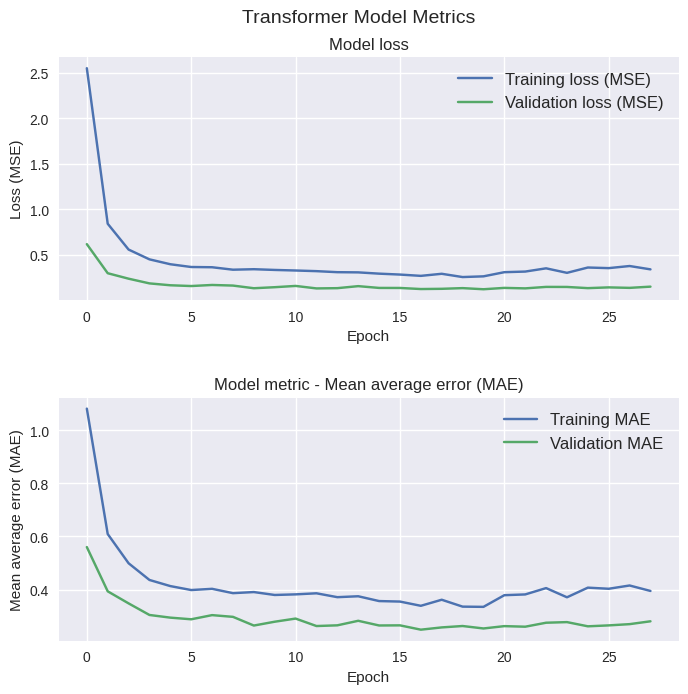

In [ ]:
# Model Metrics
fig = plt.figure(figsize=(8,12))
st = fig.suptitle("Transformer Model Metrics", fontsize=14)
st.set_y(0.92)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=12)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=12)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

In [ ]:
# Predict models closing returns
train_pred = model.predict(x_train)
val_pred = model.predict(x_val)
test_pred = model.predict(x_test)

# Evaluation of the metrics
train_eval = model.evaluate(x_train, y_train, verbose=0)
val_eval = model.evaluate(x_val, y_val, verbose=0)
test_eval = model.evaluate(x_test, y_test, verbose=0)

# Print the evaluation metrics
print('Train eval: ', train_eval)
print('Val eval: ', val_eval)
print('Test eval:', test_eval)


18/18 [==============================] - 0s 12ms/step
Train eval:  [0.19832196831703186, 0.28115570545196533, 0.36648574471473694, 1372.9986572265625]
Val eval:  [0.12257903814315796, 0.25360220670700073, 0.3511817157268524, 205.26901245117188]
Test eval: [0.08502677083015442, 0.21963970363140106, 0.27760979533195496, 166.05908203125]


In [ ]:
# Calculate R2 score
print(x_test.shape, test_pred.shape)
x_test_reshaped = x_test.reshape(-1, x_test.shape[-1])
r2 = r2_score(y_test, test_pred)
print("R-squared (R2) Score:", r2)

(550, 128, 8) (550, 1)
R-squared (R2) Score: 0.7628017148438768


['1996-07-11T00:00:00.000000000' '1996-07-12T00:00:00.000000000'
 '1996-07-15T00:00:00.000000000' ... '2017-07-05T00:00:00.000000000'
 '2017-07-06T00:00:00.000000000' '2017-07-07T00:00:00.000000000']
550
550
550


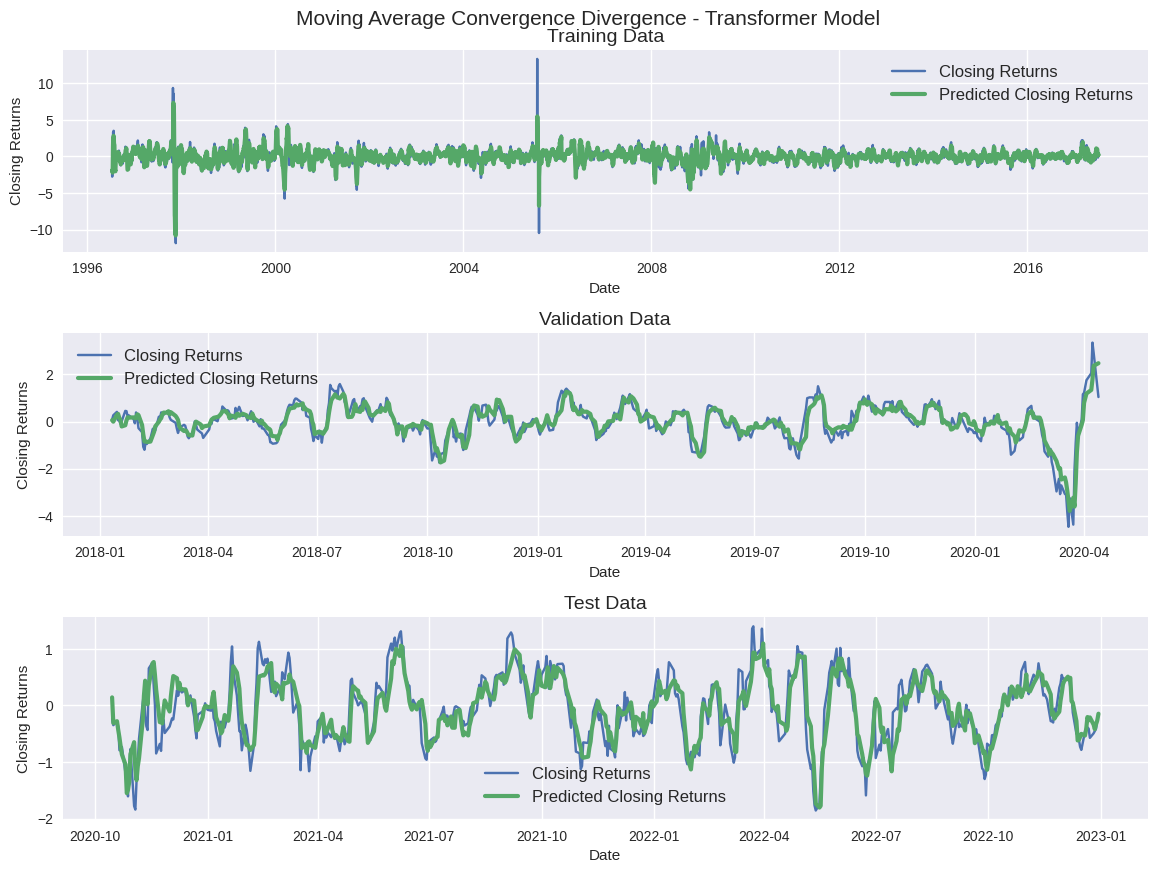

In [ ]:
fig = plt.figure(figsize=(14,10))
st = fig.suptitle("Moving Average Convergence Divergence - Transformer Model", fontsize=15)
st.set_y(0.92)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
years=[]

print(train_date)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_date,y_train)
ax11.plot(train_date,train_pred, linewidth=3)
ax11.set_title("Training Data", fontsize=14)
ax11.set_xlabel('Date')
ax11.set_ylabel('Closing Returns')
ax11.legend(loc="best", fontsize=12, labels=['Closing Returns', 'Predicted Closing Returns'])


#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_date,y_val, label='Closing Returns')
ax21.plot(val_date, val_pred, linewidth=3, label='Predicted Closing Returns' )
#ax21.set_xticks(np.arange(seq_len, val_pred.shape[0]+seq_len))
ax21.set_title("Validation Data", fontsize=14)
ax21.set_xlabel('Date')
ax21.set_ylabel('Closing Returns')
ax21.legend(loc="best", fontsize=12)

print(len(test_date))
print(len(y_test))
print(len(test_pred))
#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_date, y_test)
ax31.plot(test_date, test_pred, linewidth=3)
ax31.set_title("Test Data", fontsize=14)
ax31.set_xlabel('Date')
ax31.set_ylabel('Closing Returns')
ax31.legend(loc="best", fontsize=12, labels=['Closing Returns', 'Predicted Closing Returns'])

In [ ]:
# Forecasting future 30 days
future_period = 30
forecast = []
print(x_test.shape)
data_batch = x_test[-1]
print(data_batch)

(550, 128, 8)
[[-0.55792587 -0.66503028 -0.70377028 ... -1.20084548 -0.90474767
  -0.8918929 ]
 [-0.84344615 -0.71351064 -0.69140815 ... -1.06551058 -0.98721899
  -0.50774734]
 [-0.58701998 -0.27132311 -0.47264198 ... -0.836658   -0.99660558
  -0.05818274]
 ...
 [-0.45839176 -0.46728962 -0.50187542 ... -0.63852591 -0.73495681
  -0.08383229]
 [-0.53394899 -0.49092671 -0.49447801 ... -0.59572463 -0.73521806
  -0.00205016]
 [-0.42675809 -0.38761221 -0.29470629 ... -0.50870225 -0.71390824
   0.1306395 ]]


In [ ]:
for i in range(future_period):
    data_batch = data_batch.reshape(1, seq_len, 8)  # Reshape to match model input
    next_pred = model.predict(data_batch)
    forecast.append(next_pred[0, 0])

    # Removing old timestep and add new prediction
    data_batch = np.roll(data_batch, -1, axis=1)
    data_batch[0, -1, 0] = next_pred[0, 0]

1/1 [==============================] - 0s 31ms/step


In [ ]:
start_date_new = "2022-12-31"
end_date_new = "2023-02-14"
data_forecast = yf.download(ticker, start=start_date_new, end=end_date_new)
data_array = np.array(data_forecast.iloc[:,3].values).reshape(-1, 1)
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
forecast_prices = data_array * (1 + forecast / 100)

[*********************100%%**********************]  1 of 1 completed


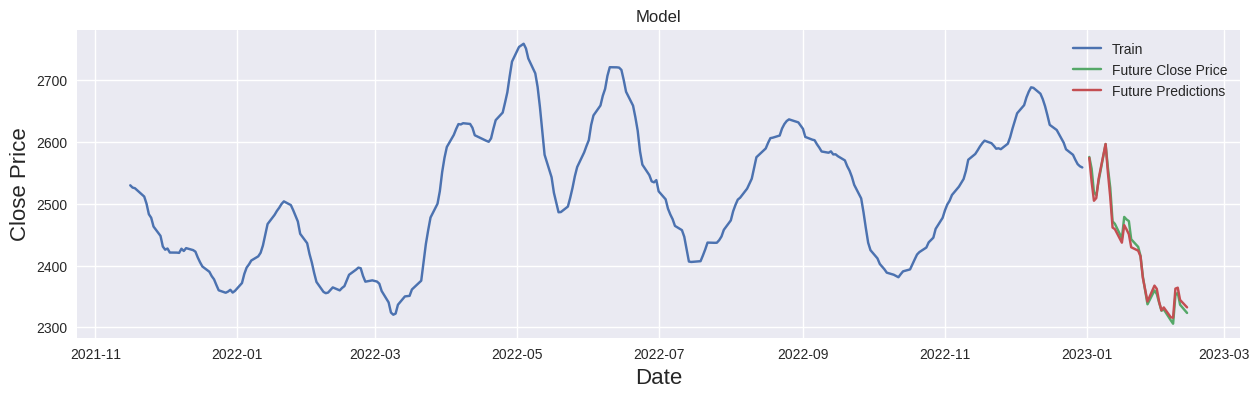

In [ ]:
data_forecast['predictions'] = forecast_prices

#data_forecast.set_index('Date', inplace=True)

plt.figure(figsize=(15,4))
plt.title('Model')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price', fontsize=16)
plt.plot(raw_data.iloc[6500:,3])
plt.plot(data_forecast[['Close', 'predictions']])
plt.legend(loc='best',labels=['Train', 'Future Close Price', 'Future Predictions'])
plt.show()

**LSTM Model**

In [ ]:
# Building LSTM model
lstm_model=keras.Sequential()
lstm_model.add(layers.LSTM(50,return_sequences=True,input_shape=x_train.shape[1:]))
lstm_model.add(layers.LSTM(50,return_sequences=True))
lstm_model.add(layers.LSTM(50))
lstm_model.add(layers.Dense(1))


In [ ]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

In [ ]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam',
              metrics=['mae',rmse, 'mape'])

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)]

lstm_history = lstm_model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=30, batch_size=64, shuffle=False)

Epoch 1/30
83/83 [==============================] - 14s 33ms/step - loss: 0.8545 - mae: 0.5860 - rmse: 0.7583 - mape: 1920.2814 - val_loss: 0.4315 - val_mae: 0.4566 - val_rmse: 0.6262 - val_mape: 313.5901
Epoch 2/30
83/83 [==============================] - 2s 18ms/step - loss: 0.6118 - mae: 0.4673 - rmse: 0.6169 - mape: 2631.9712 - val_loss: 0.2472 - val_mae: 0.3432 - val_rmse: 0.4733 - val_mape: 249.7294
Epoch 3/30
83/83 [==============================] - 1s 17ms/step - loss: 0.4293 - mae: 0.3730 - rmse: 0.5029 - mape: 2493.9780 - val_loss: 0.1443 - val_mae: 0.2696 - val_rmse: 0.3674 - val_mape: 249.0414
Epoch 4/30
83/83 [==============================] - 2s 24ms/step - loss: 0.3326 - mae: 0.3197 - rmse: 0.4344 - mape: 1981.4594 - val_loss: 0.1061 - val_mae: 0.2372 - val_rmse: 0.3192 - val_mape: 268.6158
Epoch 5/30
83/83 [==============================] - 2s 21ms/step - loss: 0.2877 - mae: 0.3005 - rmse: 0.4100 - mape: 1859.1139 - val_loss: 0.1023 - val_mae: 0.2342 - val_rmse: 0.3142 

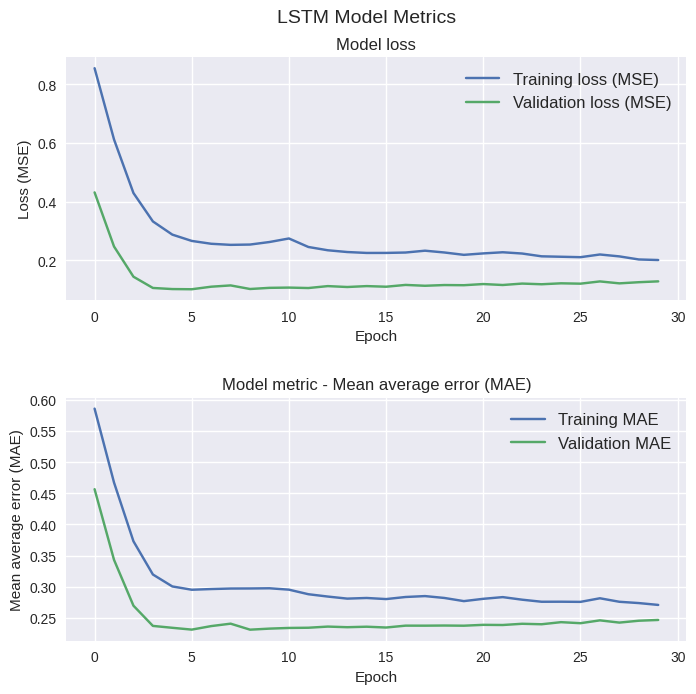

In [ ]:
# Model Metrics
fig = plt.figure(figsize=(8,12))
st = fig.suptitle("LSTM Model Metrics", fontsize=14)
st.set_y(0.92)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(lstm_history.history['loss'], label='Training loss (MSE)')
ax1.plot(lstm_history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=12)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(lstm_history.history['mae'], label='Training MAE')
ax2.plot(lstm_history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=12)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

In [ ]:
# Saving the model
if os.path.isfile('/content/drive/MyDrive/models/lstm_model.h5') is False:
  lstm_model.save('/content/drive/MyDrive/models/lstm_model.h5')

In [ ]:
# Loading the model
lstm_model = load_model('/content/drive/MyDrive/models/lstm_model.h5', custom_objects={'rmse': rmse})
lstm_model.summary()

In [ ]:
train_pred = lstm_model.predict(x_train)
val_pred = lstm_model.predict(x_val)
test_pred = lstm_model.predict(x_test)

train_eval = lstm_model.evaluate(x_train, y_train, verbose=0)
val_eval = lstm_model.evaluate(x_val, y_val, verbose=0)
test_eval = lstm_model.evaluate(x_test, y_test, verbose=0)

print(train_pred)
print(y_train)

# Print the evaluation metrics
print('Train eval: ', train_eval)
print('Val eval: ', val_eval)
print('Test eval:', test_eval)


18/18 [==============================] - 0s 7ms/step
[[-1.7388097 ]
 [-2.1928792 ]
 [-2.5015442 ]
 ...
 [ 0.05734538]
 [ 0.23122357]
 [ 0.13737781]]
[-2.45684614 -2.76386025 -1.92583319 ...  0.16534462  0.08358163
  0.39901206]
Train eval:  [0.20506365597248077, 0.2730487585067749, 0.360054612159729, 1322.0018310546875]
Val eval:  [0.12853670120239258, 0.2467445284128189, 0.34510740637779236, 198.03689575195312]
Test eval: [0.07873011380434036, 0.21500025689601898, 0.2655147314071655, 175.0247039794922]


In [ ]:
# Calculate R2 score
print(x_test.shape, test_pred.shape)
x_test_reshaped = x_test.reshape(-1, x_test.shape[-1])
r2 = r2_score(y_test, test_pred)
print("R-squared (R2) Score:", r2)

(550, 128, 8) (550, 1)
R-squared (R2) Score: 0.7803674801615206


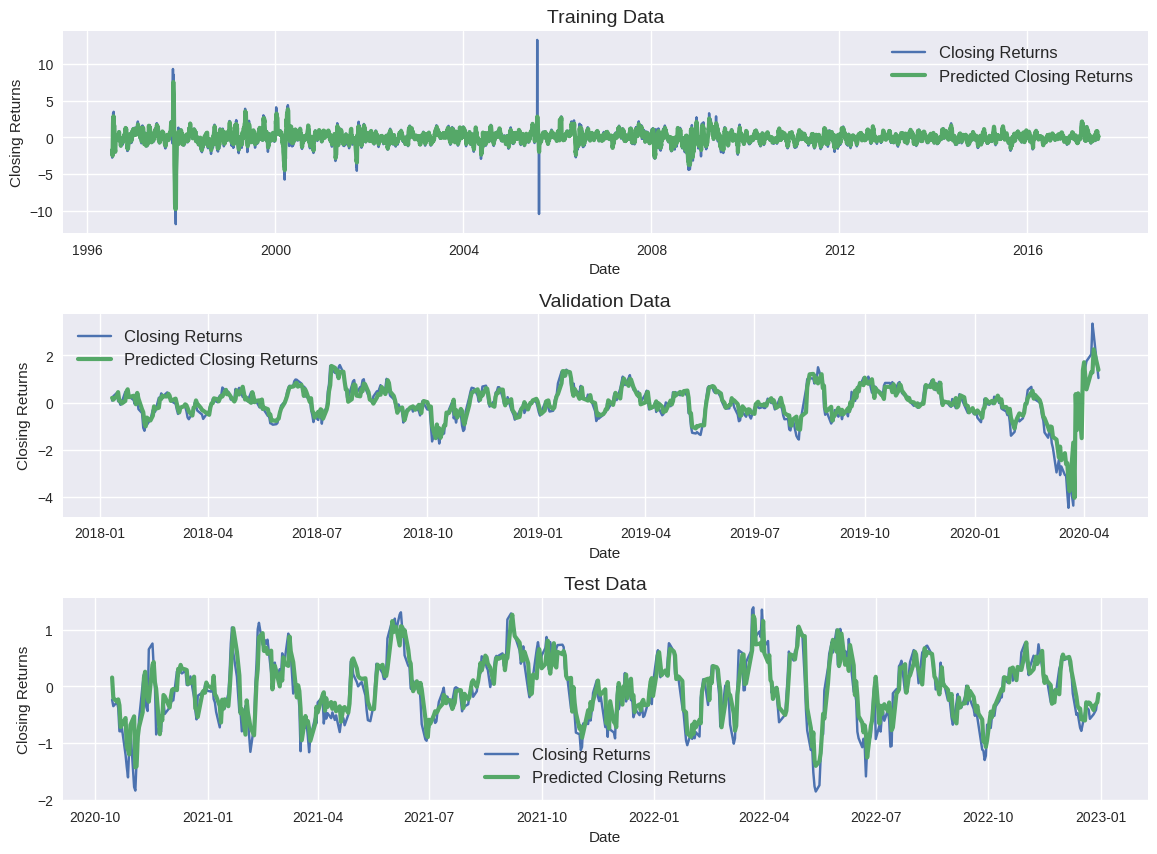

In [ ]:
fig = plt.figure(figsize=(14,10))
st.set_y(0.92)
plt.subplots_adjust(wspace=0.4, hspace=0.4)


#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_date,y_train, label='Closing Returns')
ax11.plot(train_date, train_pred, linewidth=3, label='Predicted Closing Returns')
ax11.set_title("Training Data", fontsize=14)
ax11.set_xlabel('Date')
ax11.set_ylabel('Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_date, y_val, label='Closing Returns')
ax21.plot(val_date, val_pred, linewidth=3, label='Predicted Closing Returns')
ax21.set_title("Validation Data", fontsize=14)
ax21.set_xlabel('Date')
ax21.set_ylabel('Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_date, y_test, label='Closing Returns')
ax31.plot(test_date, test_pred, linewidth=3, label='Predicted Closing Returns')
ax31.set_title("Test Data", fontsize=14)
ax31.set_xlabel('Date')
ax31.set_ylabel('Closing Returns')
ax31.legend(loc="best", fontsize=12)

In [ ]:
# Forecast for next 30 days
forecast_period = 30
forecast = []
print(x_test.shape)
current_batch = x_test[-1]
print(current_batch)

(550, 128, 8)
[[-0.55792587 -0.66503028 -0.70377028 ... -1.20084548 -0.90474767
  -0.8918929 ]
 [-0.84344615 -0.71351064 -0.69140815 ... -1.06551058 -0.98721899
  -0.50774734]
 [-0.58701998 -0.27132311 -0.47264198 ... -0.836658   -0.99660558
  -0.05818274]
 ...
 [-0.45839176 -0.46728962 -0.50187542 ... -0.63852591 -0.73495681
  -0.08383229]
 [-0.53394899 -0.49092671 -0.49447801 ... -0.59572463 -0.73521806
  -0.00205016]
 [-0.42675809 -0.38761221 -0.29470629 ... -0.50870225 -0.71390824
   0.1306395 ]]


In [ ]:
for i in range(forecast_period):
    current_batch = current_batch.reshape(1, seq_len, 8)  # Reshape to match model input
    next_pred = lstm_model.predict(current_batch)
    forecast.append(next_pred[0, 0])

    # Removing old timestep and add new prediction
    current_batch = np.roll(current_batch, -1, axis=1)
    current_batch[0, -1, 0] = next_pred[0, 0]

1/1 [==============================] - 0s 23ms/step


In [ ]:
# Downloading the data for next 30 days
start_date_new = "2022-12-31"
end_date_new = "2023-02-14"
data_forecast = yf.download(ticker, start=start_date_new, end=end_date_new)
data_array = np.array(data_forecast.iloc[:,3].values).reshape(-1, 1)
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
forecast_prices = data_array * (1 + forecast / 100)

[*********************100%%**********************]  1 of 1 completed


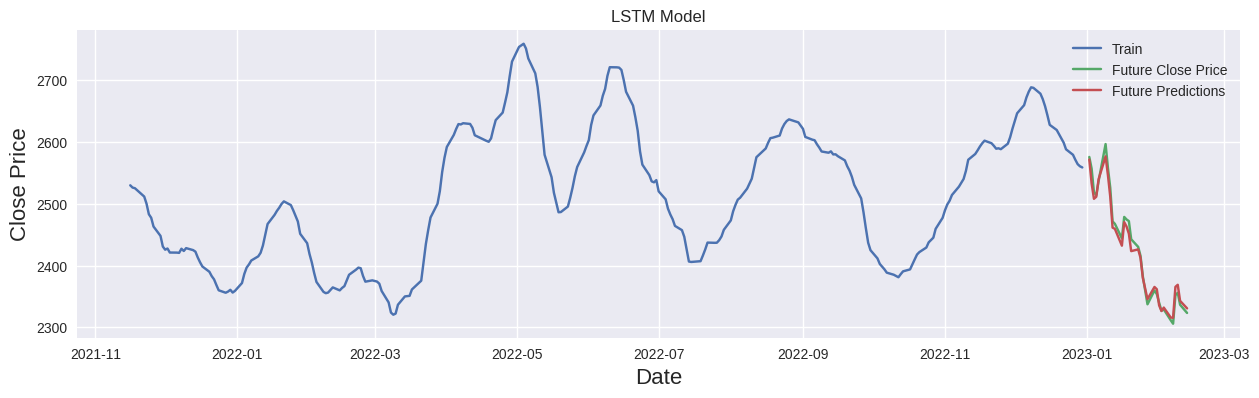

In [ ]:
data_forecast['predictions'] = forecast_prices
# Plot the forecasted and real close prices
plt.figure(figsize=(15,4))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price', fontsize=16)
plt.plot(raw_data.iloc[6500:,3])
plt.plot(data_forecast[['Close', 'predictions']])
plt.legend(['Train', 'Future Close Price', 'Future Predictions'], loc='best')
plt.show()

**RANDOMFOREST MODEL**

In [ ]:
# Columns to exclude for RF model
rf_return = 'returns'
rf_col = [col for col in df_train.columns if col != rf_return]
print(rf_col)

['Open', 'High', 'Low', 'volume_changes', 'MACD', 'MACD_signal', 'MACD_histogram']


In [ ]:

# Training data
x_train, y_train = [], []
x_train = df_train[rf_col].values
y_train = df_train.iloc[:, 3]
x_train, y_train = np.array(x_train), np.array(y_train)


# Validation data
x_val, y_val = [], []
x_val = df_val[rf_col].values
y_val = df_val.iloc[:, 3]
x_val, y_val = np.array(x_val), np.array(y_val)


# Test data
x_test, y_test = [], []
x_test = df_test[rf_col].values
y_test = df_test.iloc[:, 3]
x_test, y_test = np.array(x_test), np.array(y_test)
print(df_train.shape)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(5424, 8)
(5424, 7) (5424,)
(678, 7) (678,)
(678, 7) (678,)


In [ ]:
# Finding best parameters for RF model
rf_model = RandomForestRegressor()

grid_rf = {
'n_estimators': [20, 50, 100, 500, 1000],
'max_depth': np.arange(1, 15, 1),
'min_samples_split': [2, 10, 9],
'min_samples_leaf': np.arange(1, 15, 2, dtype=int),
'bootstrap': [True, False],
'random_state': [1, 2, 30, 42]
}
rscv = RandomizedSearchCV(estimator=rf_model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
rscv_fit = rscv.fit(x_train, y_train)
best_parameters = rscv_fit.best_params_
print(best_parameters)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'random_state': 30, 'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 12, 'bootstrap': True}


In [ ]:
# Fitting the model
rf_model = RandomForestRegressor(n_estimators=20, random_state=30, min_samples_split=2, min_samples_leaf=1, max_depth=12, bootstrap=True)

rf_model.fit(x_train, y_train)

RandomForestRegressor(max_depth=12, n_estimators=20, random_state=30)

In [ ]:
# Save the model to a file
with open('/content/drive/MyDrive/models/random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

In [ ]:
# Loading the model
with open('/content/drive/MyDrive/models/random_forest_model.pkl', 'rb') as file:
    rf_model = pickle.load(file)

In [ ]:
# Predict the closing returns of stock
train_pred = rf_model.predict(x_train)
val_pred = rf_model.predict(x_val)
test_pred = rf_model.predict(x_test)

print(y_train)
print(train_pred)

print('Train MAE:', metrics.mean_absolute_error(y_train, train_pred))
print(' MSE:', metrics.mean_squared_error(y_train, train_pred))
print(' RMSE:', np.sqrt(metrics.mean_squared_error(y_train, train_pred)))

print('Val MAE:', metrics.mean_absolute_error(y_val, val_pred))
print('MSE:', metrics.mean_squared_error(y_val, val_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_val, val_pred)))

print('Test MAE:', metrics.mean_absolute_error(y_test, test_pred))
print('MSEr:', metrics.mean_squared_error(y_test, test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, test_pred)))

[-1.29235947 -1.18671854 -1.74415715 ...  0.16534462  0.08358163
  0.39901206]
[-1.20678194 -1.16128426 -1.77574062 ...  0.11356469  0.07853441
  0.3796047 ]
Train MAE: 0.06412672562299791
 MSE: 0.008277252752539157
 RMSE: 0.09097940839848959
Val MAE: 0.07960930075382523
MSE: 0.013568980252062428
RMSE: 0.11648596590174469
Test MAE: 0.08244882191103622
MSEr: 0.011748201903915586
RMSE: 0.10838912262729866


In [ ]:
from sklearn.metrics import r2_score

# Calculate R2 score
print(x_test.shape, test_pred.shape)
x_test_reshaped = x_test.reshape(-1, x_test.shape[-1])
r2 = r2_score(y_test, test_pred)
print("R-squared (R2) Score:", r2)

(678, 7) (678,)
R-squared (R2) Score: 0.9743891497575518


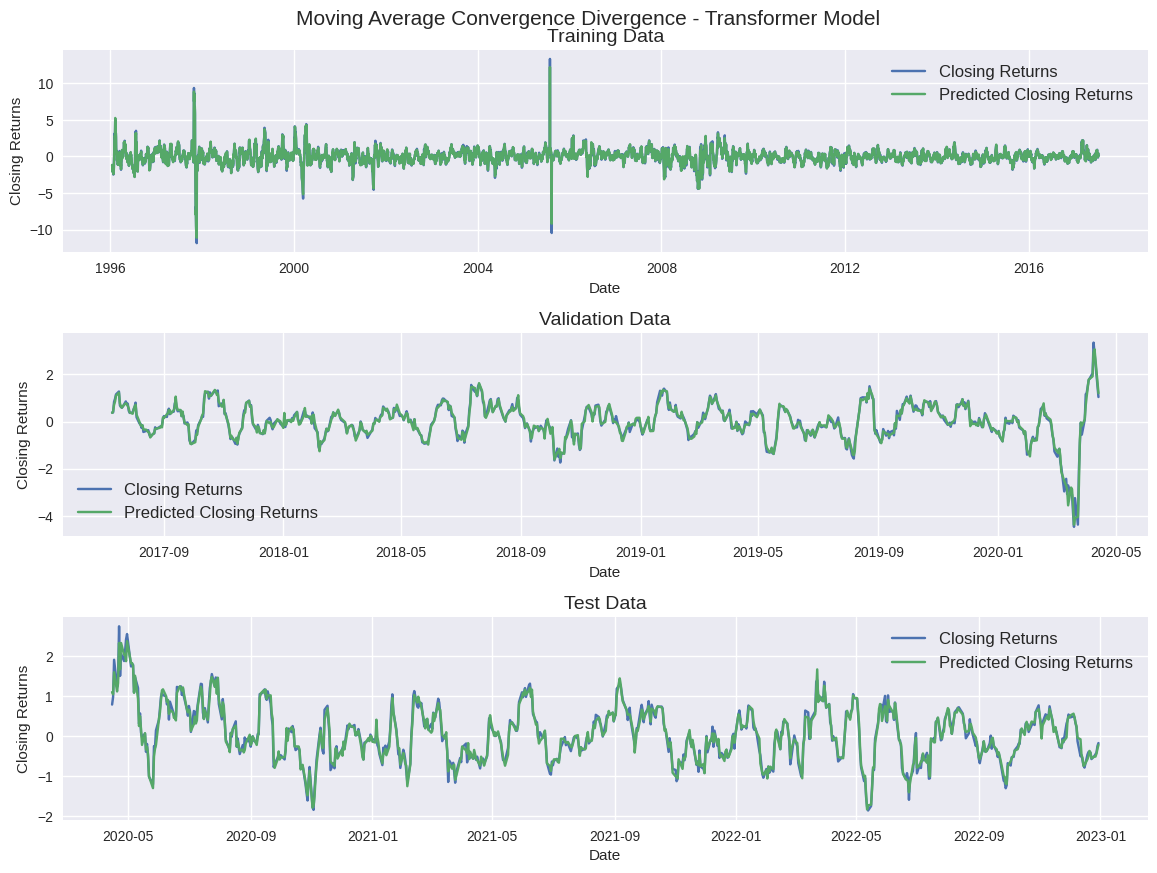

In [ ]:
fig = plt.figure(figsize=(14,10))
st = fig.suptitle("Moving Average Convergence Divergence - Transformer Model", fontsize=15)
st.set_y(0.92)
plt.subplots_adjust(wspace=0.4, hspace=0.4)


#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(df_train.index.values,y_train, label='Closing Returns')
ax11.plot(df_train.index.values,train_pred,  label='Predicted Closing Returns')
ax11.set_title("Training Data", fontsize=14)
ax11.set_xlabel('Date')
ax11.set_ylabel('Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(df_val.index.values,val_data[:,3], label='Closing Returns')
ax21.plot(df_val.index.values,val_pred,  label='Predicted Closing Returns')
ax21.set_title("Validation Data", fontsize=14)
ax21.set_xlabel('Date')
ax21.set_ylabel('Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(df_test.index.values, test_data[:,3], label='Closing Returns')
ax31.plot(df_test.index.values, test_pred, label='Predicted Closing Returns')
ax31.set_title("Test Data", fontsize=14)
ax31.set_xlabel('Date')
ax31.set_ylabel('Closing Returns')
ax31.legend(loc="best", fontsize=12)

In [ ]:
# Forecasting for next future 30 days
forecast_period = 30
forecast = []
print(x_test.shape)
current_batch = x_test[-100:]
print(current_batch.shape)
print(len(current_batch))

(678, 7)
(100, 7)
100


In [ ]:
for i in range(forecast_period):
    #current_batch = current_batch # Reshape to match model input
    next_pred = rf_model.predict(current_batch)
    forecast.append(next_pred[0])

    # Remove old time step and add new one
    current_batch = np.roll(current_batch, -1, axis=1)
    current_batch[-1, 0] = next_pred[0]

In [ ]:
start_date_new = "2022-12-31"
end_date_new = "2023-02-14"
data_forecast = yf.download(ticker, start=start_date_new, end=end_date_new)
data_array = np.array(data_forecast.iloc[:,3].values).reshape(-1, 1)
forecast = np.array(forecast).reshape(-1, 1)
print(len(forecast))

forecast = scaler.inverse_transform(forecast)
print(len(forecast))
forecast_prices = data_array * (1 + forecast / 100)

[*********************100%%**********************]  1 of 1 completed
30
30


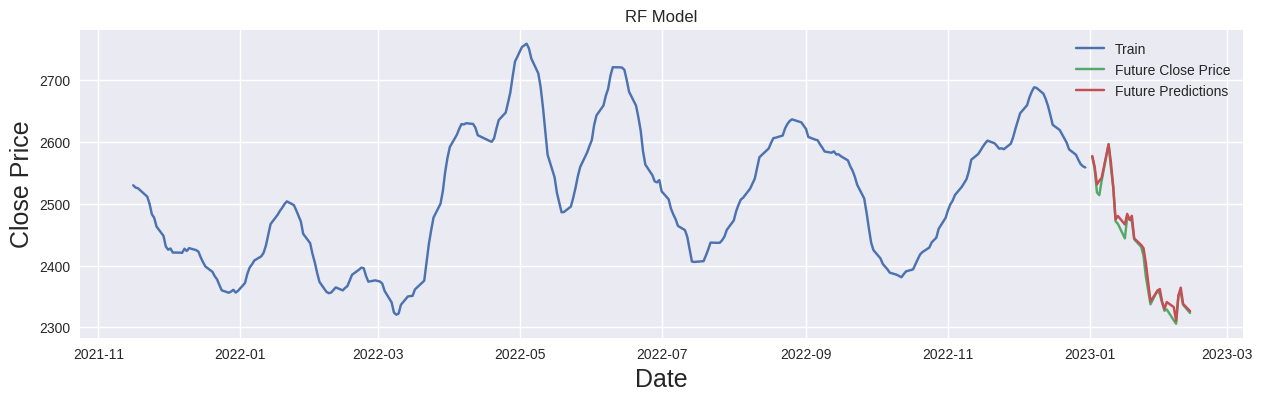

In [ ]:
data_forecast['predictions'] = forecast_prices
# Plotting the forecasted prices and real prices
plt.figure(figsize=(15,4))
plt.title('RF Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(raw_data.iloc[6500:,3])
plt.plot(data_forecast[['Close', 'predictions']])
plt.legend(['Train', 'Future Close Price', 'Future Predictions'], loc='best')
plt.show()